# How to acquire data with Acoular
> How to acquire data with Acoular
- tags: [data acquisition]
- author: Adam Kujawski
- comments: true

Acoular is a Python library that processes multichannel data (up to a few hundred channels) from acoustic measurements with a microphone array which is stored in an HDF5 file. This blog post explains how to acquire data with Acoular and save that data in an HDF5 file.

It is rquired that the current environment includes the `sounddevice` library, which ships with Acoular when the framework is installed with all dependencies, i.e.:

```console
pip install acoular['full']
```

Alternatively, `sounddevice` can be installed using conda

```console
conda install -c conda-forge python-sounddevice
```

or pip

```console
pip install sounddevice
```





In [1]:
import sounddevice as sd

sd.query_devices()

   0 WD15 Dock: USB Audio (hw:1,0), ALSA (2 in, 2 out)
   1 WD15 Dock: USB Audio #1 (hw:1,1), ALSA (0 in, 2 out)
   2 Scarlett 2i2 USB: Audio (hw:2,0), ALSA (2 in, 2 out)
   3 USB 2.0 Camera: Audio (hw:3,0), ALSA (2 in, 0 out)
   4 sysdefault, ALSA (128 in, 128 out)
   5 front, ALSA (0 in, 2 out)
   6 surround40, ALSA (0 in, 2 out)
   7 surround51, ALSA (0 in, 2 out)
   8 surround71, ALSA (0 in, 2 out)
   9 hdmi, ALSA (0 in, 2 out)
* 10 default, ALSA (128 in, 128 out)
  11 dmix, ALSA (0 in, 2 out)

Acoular provides a class for streaming audio data via the `SoundDeviceSamplesGenerator` class, which uses the sounddevice library under the hood. Here, we instantiate this class and select the desired audio interface by setting its device index. Since we only want to acquire the data of a single channel, we set `numchannels=1`. The sample frequency of the audio interface equals to 44.1 kHz, which can be inferred from the object instance.

In [2]:
import acoular

dev = acoular.SoundDeviceSamplesGenerator(
    device = 2,
    numchannels = 1,
)

print(dev.sample_freq)

/home/kujawski/micromamba/envs/py311/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


44100.0


Next, we want to acquire a signal with a length of two seconds. Therefore, the input stream is read block by block with a blocksize of 256 samples. We use the `return_result` function to retrieve all blocks in one go.  

In [3]:
dev.numsamples = int(2 * dev.sample_freq)

signal = acoular.tools.return_result(dev, num=256)


{'name': 'Scarlett 2i2 USB: Audio (hw:2,0)', 'index': 2, 'hostapi': 0, 'max_input_channels': 2, 'max_output_channels': 2, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0} 44100.0


The Numpy array contains the time data on the first and the number of channels on the second axis. 

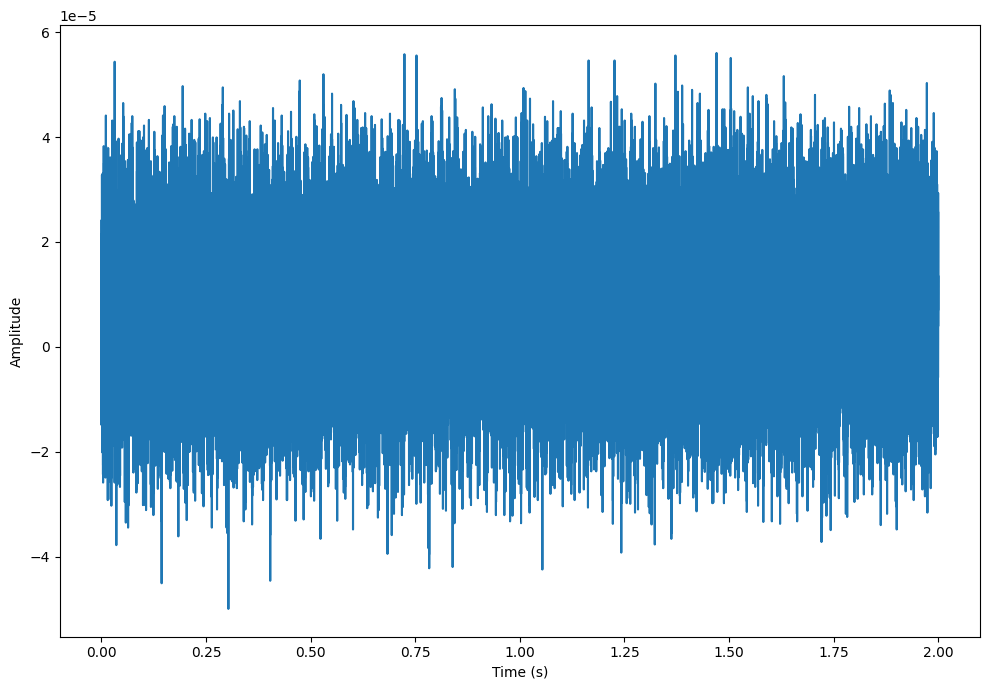

In [4]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(signal.shape[0]) / dev.sample_freq
plt.figure(figsize=(10,7))
plt.plot(t, signal[:,0])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

Instead of or in addition to acquiring the time data, it is possible to add further processing steps by means of classes defined in Acoular's `tprocess.py` module. For example, one may use the `WriteH5` and the `WriteWAV` class to save the full stream to an HDF5 file and to write a particular channel to a WAV file for listening. 

In [5]:
hdf5 = acoular.WriteH5(
    source = dev,
    name = 'sounddevice.h5',
)

wav = acoular.WriteWAV(
    source = hdf5,
    name = 'sounddevice.wav',
    channels = [0],    
)

In the previous code snippet, we created a processing chain consisting of:

    (1) reading data from the audio interface (`SoundeDeviceSamplesGenerator`)
    (2) writing the data to HDF5 file (`WriteH5`)
    (3) create a .wav file using the first channel of the data

Due to the lazy evaluation paradigm, nothing has been processed yet. To start the acquisition and writing, we have two choices:

    (1) calling `wav.result(num=256)` to create a generator which yields the data block-wise
    (2) calling `wav.save()` which runs the processing chain with a single function call and does not return the data

This time, we go with option (2)

In [6]:
wav.save()

{'name': 'Scarlett 2i2 USB: Audio (hw:2,0)', 'index': 2, 'hostapi': 0, 'max_input_channels': 2, 'max_output_channels': 2, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0} 44100.0
{'name': 'Scarlett 2i2 USB: Audio (hw:2,0)', 'index': 2, 'hostapi': 0, 'max_input_channels': 2, 'max_output_channels': 2, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': 0.034829931972789115, 'default_samplerate': 44100.0} 44100.0


As usual, we can use the `TimeSamples` object to read the data back for further post-processing

1
88200
44100.0


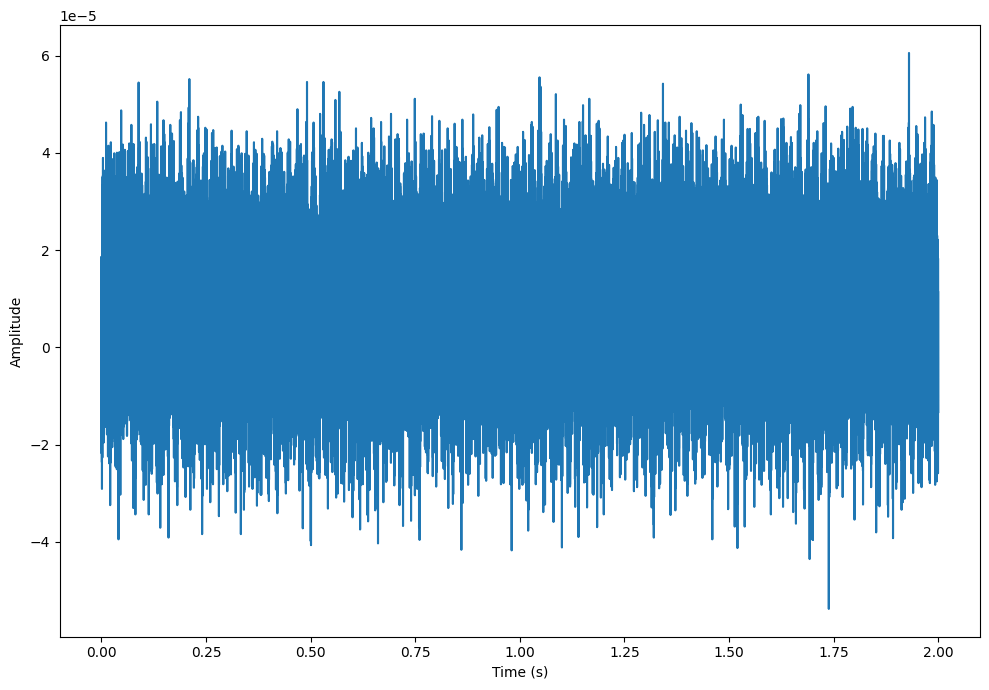

In [10]:
ts = acoular.TimeSamples(name='sounddevice.h5')

print(ts.numchannels)
print(ts.numsamples)
print(ts.sample_freq)


signal = acoular.tools.return_result(ts, num=256)
t = np.arange(signal.shape[0]) / dev.sample_freq
plt.figure(figsize=(10,7))
plt.plot(t, signal[:,0])
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()